In [5]:
# Import libraries

import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,ImageDataGenerator, array_to_img
from tensorflow.keras.applications import EfficientNetB1

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten,Dense,Conv2D,Dropout,GlobalAveragePooling2D,GlobalAvgPool2D

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
import imutils

In [6]:
# Create Directory for Training Data

os.mkdir("./contents/Crop-Brain-MRI")
os.mkdir("./contents/Crop-Brain-MRI/tumor")
os.mkdir("./contents/Crop-Brain-MRI/no_tumor")

FileExistsError: [WinError 183] Cannot create a file when that file already exists: './contents/Crop-Brain-MRI'

In [7]:
# Create Directory for Testing Data

os.mkdir("./contents/Test-Brain-MRI")
os.mkdir("./contents/Test-Brain-MRI/tumor")
os.mkdir("./contents/Test-Brain-MRI/no_tumor")

FileExistsError: [WinError 183] Cannot create a file when that file already exists: './contents/Test-Brain-MRI'

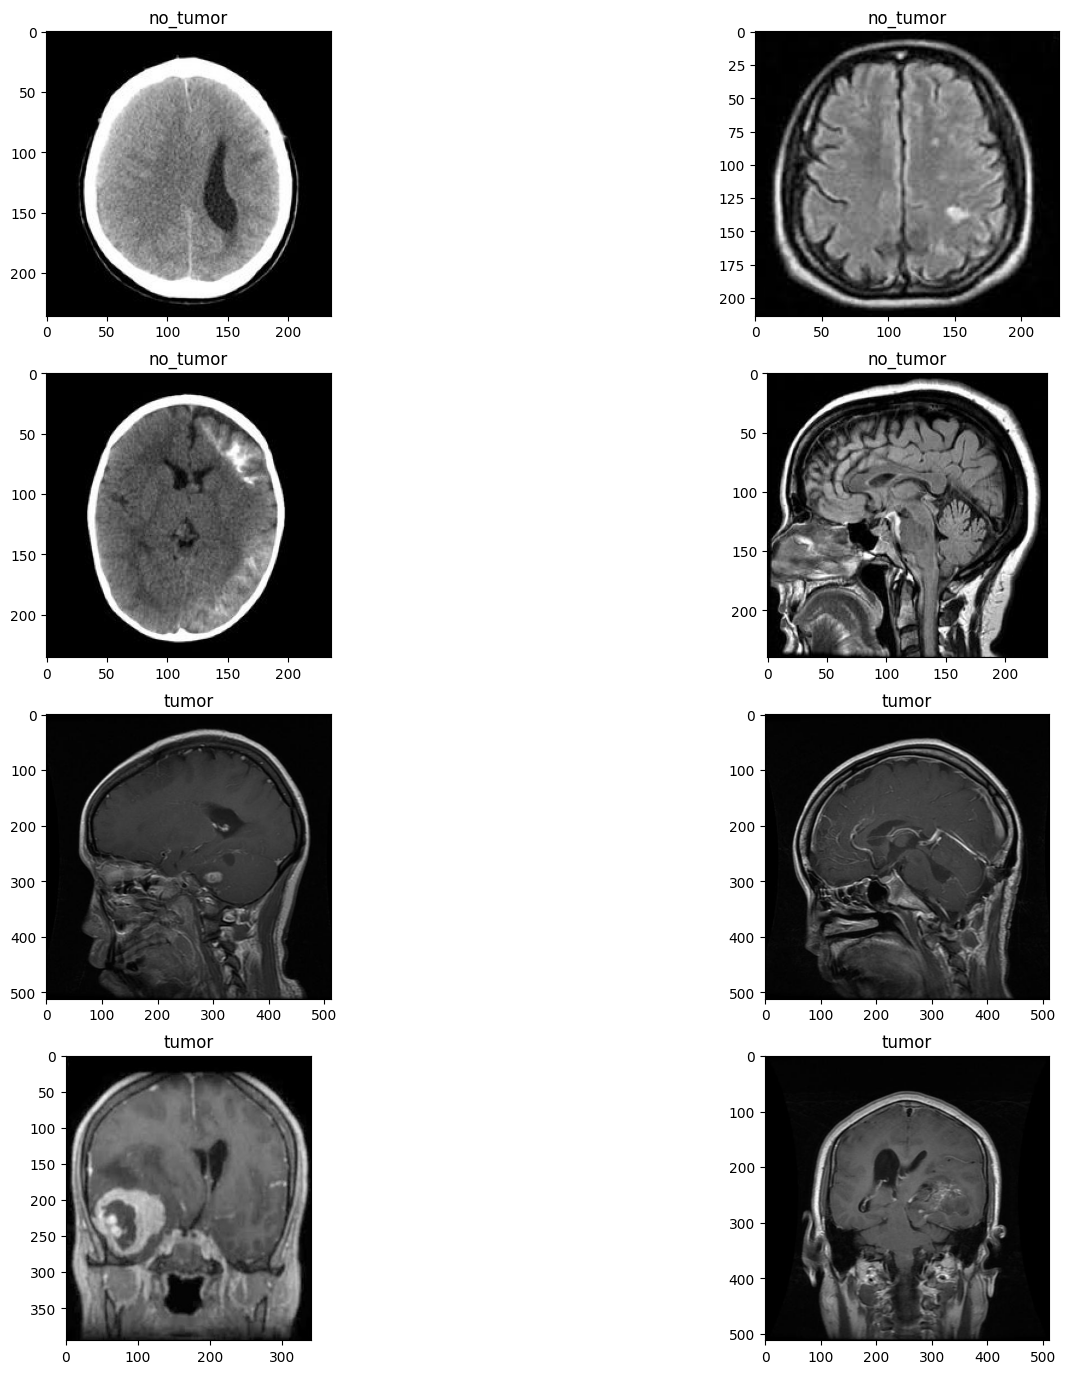

In [8]:
# Data Visualisation

train_dir = "./contents/Training/"
test_dir = "./contents/Testing/"

classes = os.listdir("./contents/Training")

files_path_dict = {}

for c in classes:
  files_path_dict[c] = list(map(lambda x :train_dir+c+'/'+x, os.listdir(train_dir+c)))

plt.figure(figsize=(17,17))
index = 0

for c in classes:
  random.shuffle(files_path_dict[c])
  path_list = files_path_dict[c][:5]

  for i in range (1,5):
    index += 1
    plt.subplot(4, 2, index)
    plt.imshow(load_img(path_list[i]))
    plt.title(c)

In [9]:
# Function to crop images

def crop_image(image, plot=False):
    
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.GaussianBlur(img_gray, (5, 5), 0)
    
    img_thresh = cv2.threshold(img_gray, 45, 255, cv2.THRESH_BINARY)[1]
    img_thresh = cv2.erode(img_thresh, None, iterations=2)
    img_thresh = cv2.dilate(img_thresh, None, iterations=2)

    contours = cv2.findContours(img_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    c = max(contours, key=cv2.contourArea)

    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image

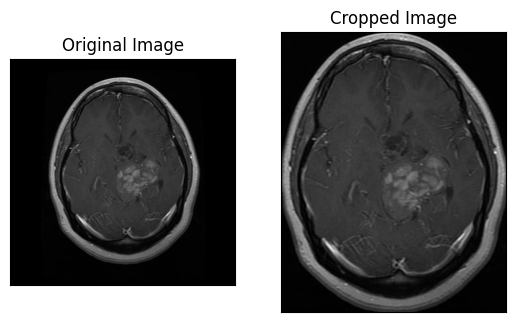

In [10]:
# Check the crop

example_img = cv2.imread("./contents/Training/tumor/gg (1).jpg")
cropped_image_example = crop_image(example_img, plot=True)

In [11]:
# Crop the Training Images and Save to respective directories
tumor = train_dir + "tumor"
no_tumor = train_dir + "no_tumor"

j = 0
for i in tqdm(os.listdir(tumor)):
  path = os.path.join(tumor, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "./contents/Crop-Brain-MRI/tumor/"+ str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j = j+1

j = 0
for i in tqdm(os.listdir(no_tumor)):
  path = os.path.join(no_tumor, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "./contents/Crop-Brain-MRI/no_tumor/" +str(j) +".jpg"
    cv2.imwrite(save_path, img)
    j = j+1

100%|████████████████████████████████████████████████████████████████████████████████| 501/501 [00:05<00:00, 97.86it/s]


In [12]:
# Crop the Testing Images and Save to respective directories
tumor = test_dir + "tumor"
no_tumor = test_dir + "no_tumor"

j = 0
for i in tqdm(os.listdir(tumor)):
  path = os.path.join(tumor, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "./contents/Test-Brain-MRI/tumor/"+ str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j = j+1

j = 0
for i in tqdm(os.listdir(no_tumor)):
  path = os.path.join(no_tumor, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "./contents/Test-Brain-MRI/no_tumor/" +str(j) +".jpg"
    cv2.imwrite(save_path, img)
    j = j+1

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 51.79it/s]


In [13]:
# Use Image Data Generator
#Preprocessing

train_datagen = ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)

In [15]:
training_set = train_datagen.flow_from_directory('./contents/Crop-Brain-MRI',target_size = (64,64),batch_size = 32,class_mode = 'binary')

test_datagen = ImageDataGenerator(rescale=1./255)

test_set = test_datagen.flow_from_directory('./contents/Test-Brain-MRI',target_size = (64,64),batch_size = 32,class_mode = 'binary')

Found 1000 images belonging to 2 classes.
Found 12 images belonging to 2 classes.


In [16]:
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2

In [34]:
#Building CNN

#Initialising the CNN
cnn=tf.keras.models.Sequential();


#Step1: Convolution
cnn.add(tf.keras.layers.Conv2D(filters=32,padding='same',kernel_size=3,activation='relu',strides=2,input_shape=[64,64,3]))


#Step2: Pooling
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))

#Adding Second Convolution Layer
cnn.add(tf.keras.layers.Conv2D(filters=32,padding='same',kernel_size=3,activation='relu',strides=2,input_shape=[64,64,3]))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))

#Step3 : Flattening
cnn.add(tf.keras.layers.Flatten())

#Step4 : Full Connection
cnn.add(tf.keras.layers.Dense(units=128,activation='relu'))

#Step5 : Output Layer
cnn.add(Dense(1,kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='linear'))


In [35]:
cnn.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 8, 8, 32)          9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 4, 4, 32)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 128)             

In [93]:
cnn.compile(optimizer='adam',loss='hinge',metrics=['accuracy'])

In [96]:
elst=EarlyStopping(monitor='val_loss',patience=5,mode='min')
save_ck=ModelCheckpoint('detection_model.hdf5',save_best_only=True,monitor='val_loss',mode='min')

r=cnn.fit(x=training_set,validation_data=test_set,callbacks=[save_ck],epochs=50)

Epoch 1/50
32/32 [==============================] - 8s 241ms/step - loss: 0.1120 - accuracy: 0.9610 - val_loss: 0.0203 - val_accuracy: 1.0000
Epoch 2/50
32/32 [==============================] - 7s 209ms/step - loss: 0.0760 - accuracy: 0.9780 - val_loss: 0.1706 - val_accuracy: 0.8333
Epoch 3/50
32/32 [==============================] - 7s 206ms/step - loss: 0.0895 - accuracy: 0.9710 - val_loss: 0.1282 - val_accuracy: 0.9167
Epoch 4/50
32/32 [==============================] - 7s 207ms/step - loss: 0.0780 - accuracy: 0.9740 - val_loss: 0.0752 - val_accuracy: 0.9167
Epoch 5/50
32/32 [==============================] - 7s 208ms/step - loss: 0.0829 - accuracy: 0.9680 - val_loss: 0.0875 - val_accuracy: 1.0000
Epoch 6/50
32/32 [==============================] - 7s 221ms/step - loss: 0.0755 - accuracy: 0.9670 - val_loss: 0.0609 - val_accuracy: 1.0000
Epoch 7/50
32/32 [==============================] - 6s 191ms/step - loss: 0.0679 - accuracy: 0.9750 - val_loss: 0.0634 - val_accuracy: 1.0000
Epoch 

In [97]:
cnn.evaluate(test_set)

1/1 [==============================] - 0s 123ms/step - loss: 0.2128 - accuracy: 0.8333


[0.2127579003572464, 0.8333333134651184]

In [102]:
import numpy as np
from tensorflow.keras.preprocessing import image
test_image = image.load_img('./contents/Crop-Brain-MRI/no_tumor/1.jpg', target_size = (64,64))
test_image = image.img_to_array(test_image)
test_image=test_image/255
test_image = np.expand_dims(test_image, axis = 0)
result = cnn.predict(test_image)


1/1 [==============================] - 0s 188ms/step


In [103]:
result

array([[-4.425172]], dtype=float32)

In [104]:
if result[0]>0:
    print("brain is having tumor")
else:
    print("brain is not having tumor")

brain is not having tumor
